In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital import *
print("using device: ", device)

Random seed set to 333
using device:  cuda


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'testvital_30000'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col_ls = ['cl_event', 'ts_description', 'demo'],#], 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother'],
    model_name = model_name,
    downsample = True,
    downsample_size = 30000,
    embedded_dim = 512,
    batch_size = 512, # Data loader settings
    patience = 200, # Training settings
    num_saves = 50,
    num_epochs = 100,
    init_lr = 1e-4,
    text_config = text_config,
    **{'3d': True}  # Add this line
)
config_dict = get_config_dict()

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=72)]: Done 380 tasks      | elapsed:    3.8s
[Parallel(n_jobs=72)]: Done 2170 tasks      | elapsed:    6.3s
[Parallel(n_jobs=72)]: Done 5392 tasks      | elapsed:    9.8s
[Parallel(n_jobs=72)]: Done 9792 tasks      | elapsed:   11.2s
[Parallel(n_jobs=72)]: Done 14992 tasks      | elapsed:   12.5s
[Parallel(n_jobs=72)]: Done 20992 tasks      | elapsed:   14.1s
[Parallel(n_jobs=72)]: Done 27792 tasks      | elapsed:   15.8s
[Parallel(n_jobs=72)]: Done 35392 tasks      | elapsed:   17.7s
[Parallel(n_jobs=72)]: Done 43792 tasks      | elapsed:   19.8s
[Parallel(n_jobs=72)]: Done 52992 tasks      | elapsed:   22.0s
[Parallel(n_jobs=72)]: Done 62992 tasks      | elapsed:   24.8s
[Parallel(n_jobs=72)]: Done 65353 out of 65353 | elapsed:   25.4s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  Moderate variability.  Very low amount of consecutive increases. Very high amount of consecutive unchanging values.    

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=72)]: Done 504 tasks      | elapsed:    0.3s
[Parallel(n_jobs=72)]: Done 3440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=72)]: Done 10640 tasks      | elapsed:    2.7s
[Parallel(n_jobs=72)]: Done 19440 tasks      | elapsed:    4.7s
[Parallel(n_jobs=72)]: Done 29840 tasks      | elapsed:    7.3s
[Parallel(n_jobs=72)]: Done 41840 tasks      | elapsed:   10.1s
[Parallel(n_jobs=72)]: Done 55440 tasks      | elapsed:   13.3s
[Parallel(n_jobs=72)]: Done 61570 out of 61570 | elapsed:   14.8s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  High variability.  Low amount of consecutive increases. Very high amount of consecutive unchanging values.    
After downsampling:
cl_event
This infant will survive.           30000
This infant will die in 7 days.       384
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           30000
This infant will die in 7 days.       241
Name: count, dtype: int64


/home/jq2uw/.local/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will survive.           30000
This infant will die in 7 days.       384
Name: count, dtype: int64
cl_event
This infant will survive.           30000
This infant will die in 7 days.       241
Name: count, dtype: int64


In [5]:
# # for testing purposes way 1
# %load_ext autoreload
# %autoreload 1
# %aimport train

# # way 2 if way 1 not working
# %load_ext autoreload
# %autoreload 2
# import importlib
# import train
# importlib.reload(train)

## Customize VITAL Model

In [6]:
# customize model
if overwrite:    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'],       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path)
    model = config_dict['model_init']


Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─LocalNorm: 2-1                                                  --
│    └─Sequential: 2-2                                                 --
│    │    └─MultiLSTMEncoder: 3-1                                      3,295,104
│    │    └─LayerNorm: 3-2                                             512
│    │    └─Linear: 3-3                                                131,584
│    │    └─LeakyReLU: 3-4                                             --
│    │    └─LayerNorm: 3-5                                             1,024
│    │    └─Linear: 3-6                                                262,656
│    │    └─LeakyReLU: 3-7                                             --
│    │    └─LayerNorm: 3-8                                             1,024
│    │    

In [7]:
overwrite = True
if overwrite or not os.path.exists(model_path):
    for i in range(config_dict['num_saves']):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        train_type='joint',
                                                        alpha = 1/1000)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    eval_dict_ts2txt = torch.load(output_dir+'/evals_ts2txt.pth')
    eval_dict_txt2ts = torch.load(output_dir+'/evals_txt2ts.pth')
    # eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
    # eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)

Epoch [1/100]
	Training Loss: 30.073363 (clip: 9.393402, vae: 20679.960059)
	Testing Loss: 27.121631 (clip: 8.389332, vae: 18732.298438)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [11/100]
	Training Loss: 24.437745 (clip: 6.484140, vae: 17953.604199)
	Testing Loss: 22.344967 (clip: 6.323719, vae: 16021.247217)
	Learning Rate: 0.000100000
beta: 0.001
Epoch [21/100]
	Training Loss: 22.093680 (clip: 6.267761, vae: 15825.919189)
	Testing Loss: 19.864294 (clip: 6.216114, vae: 13648.179232)
	Learning Rate: 0.000100000
beta: 0.002
Epoch [31/100]
	Training Loss: 21.213682 (clip: 6.240618, vae: 14973.063997)
	Testing Loss: 19.017766 (clip: 6.203690, vae: 12814.074740)
	Learning Rate: 0.000100000
beta: 0.003
Epoch [41/100]
	Training Loss: 20.292713 (clip: 6.236312, vae: 14056.400195)
	Testing Loss: 18.021913 (clip: 6.202192, vae: 11819.719743)
	Learning Rate: 0.000100000
beta: 0.004
Epoch [51/100]
	Training Loss: 19.610317 (clip: 6.232839, vae: 13377.477653)
	Testing Loss: 17.344125 (clip: 6.20

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9ac3dfc590>>
Traceback (most recent call last):
  File "/home/jq2uw/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 



Training interrupted by user. Saving current progress...



KeyboardInterrupt



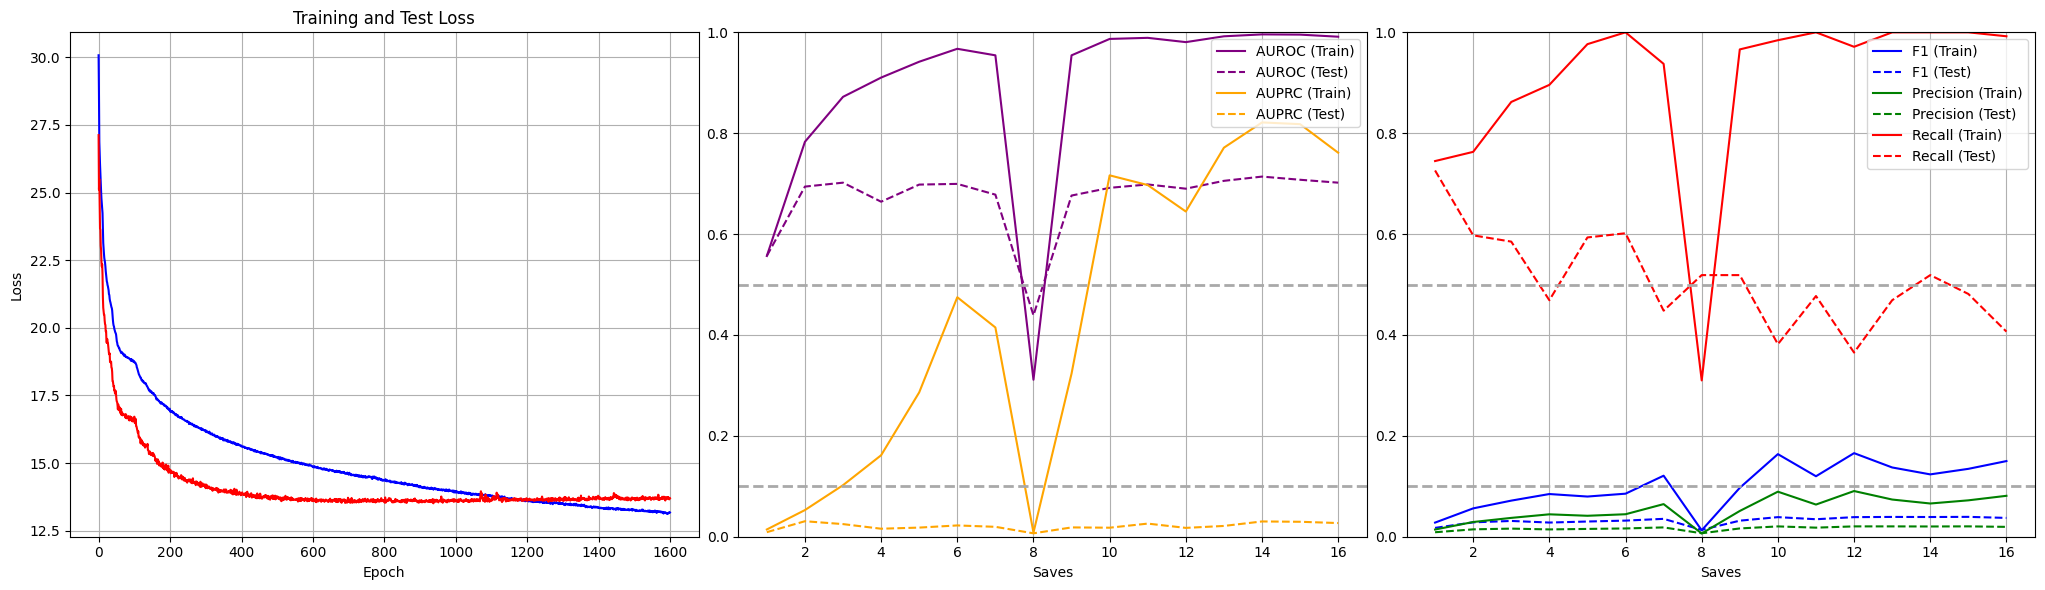

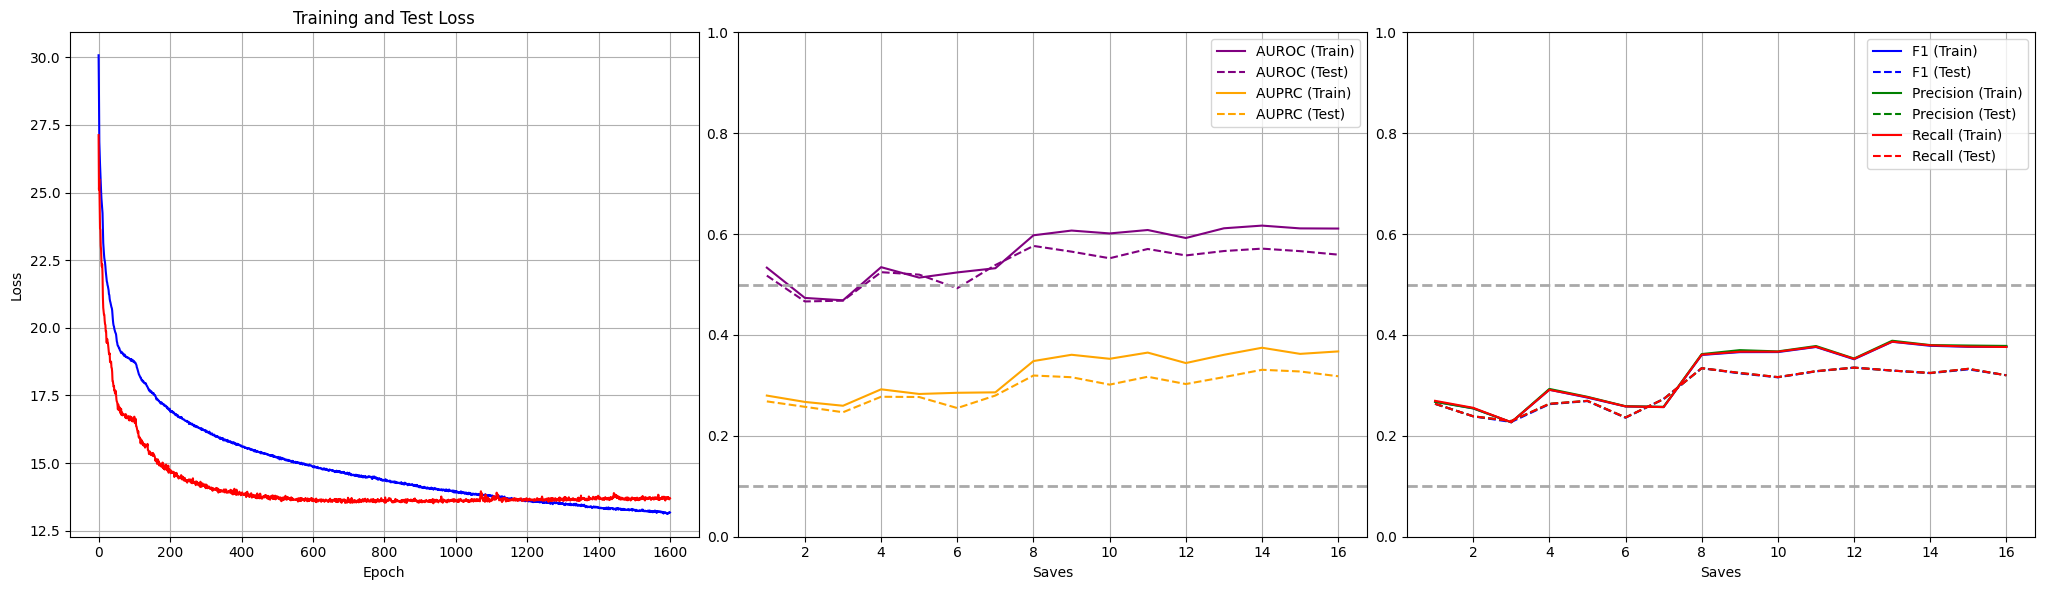

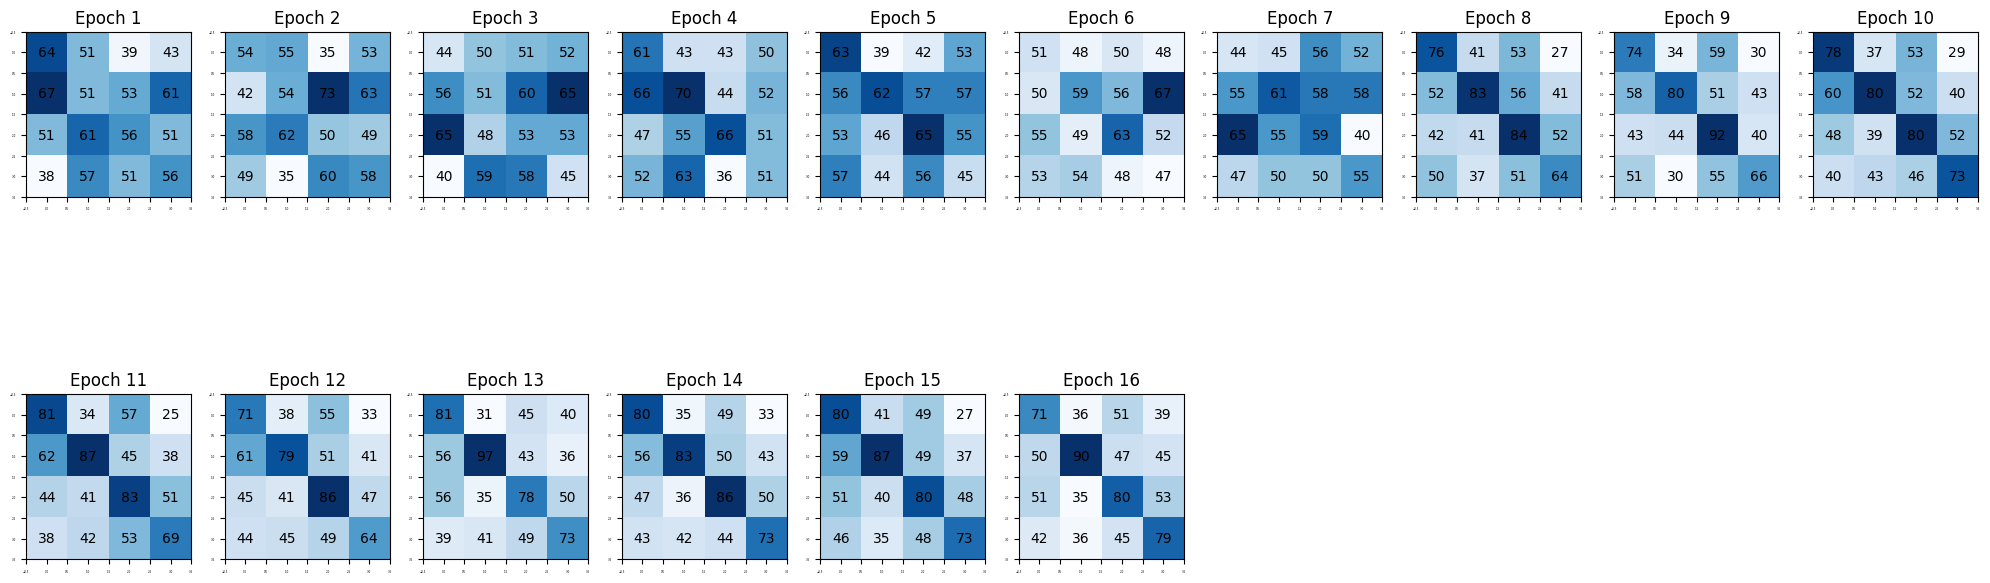

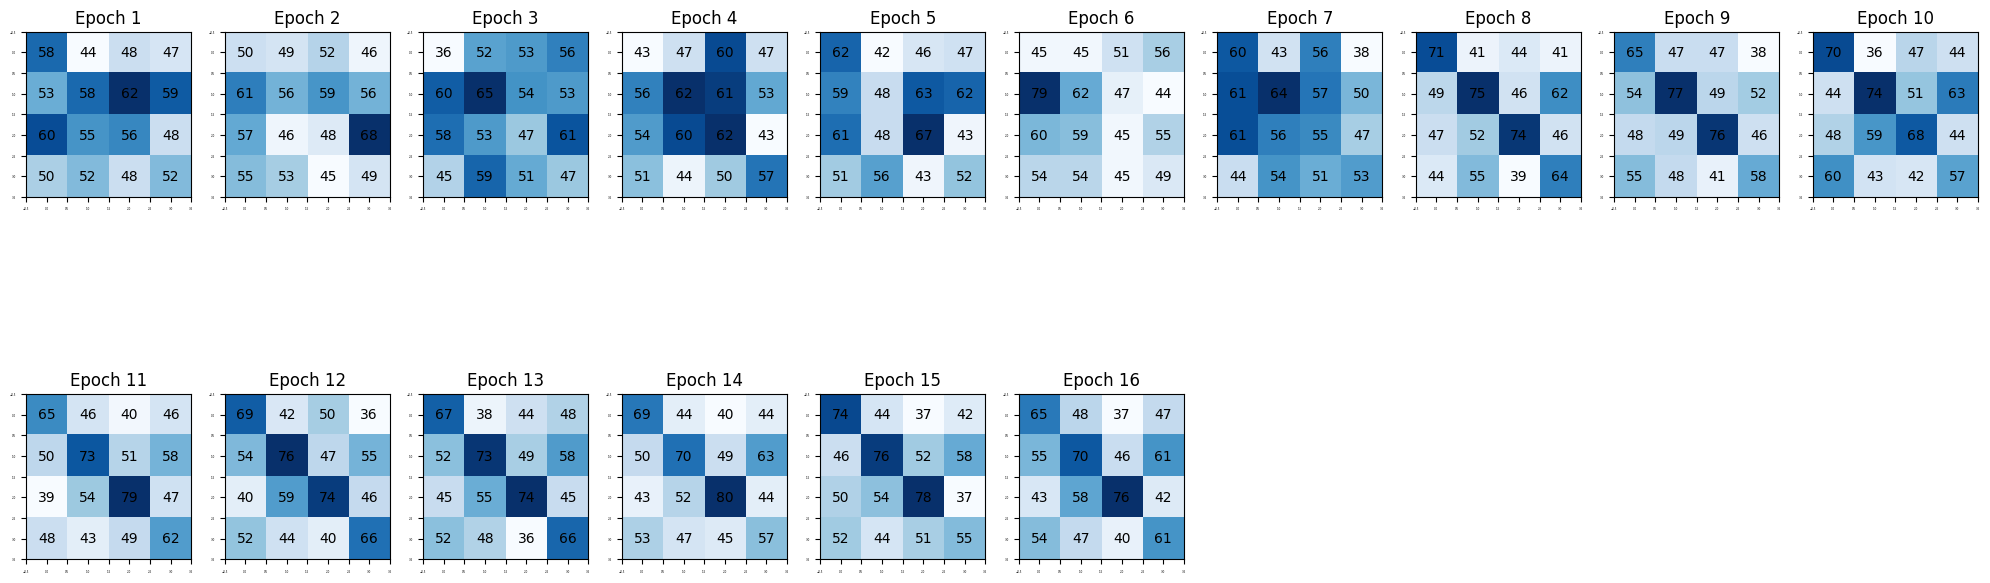

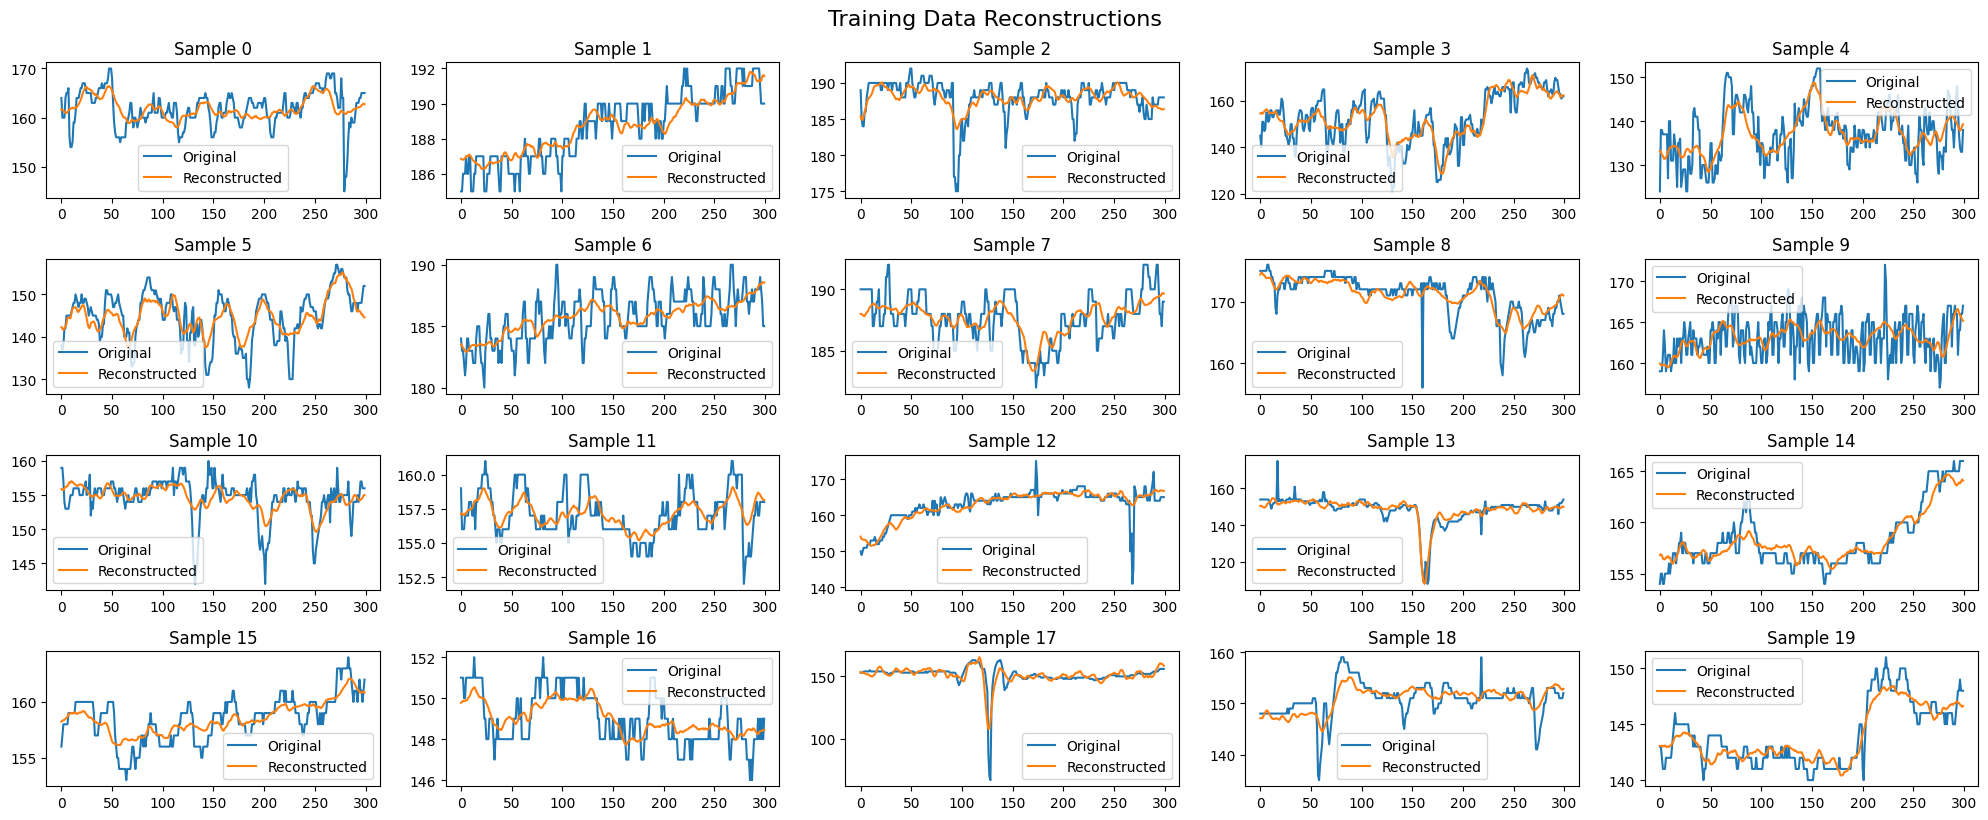

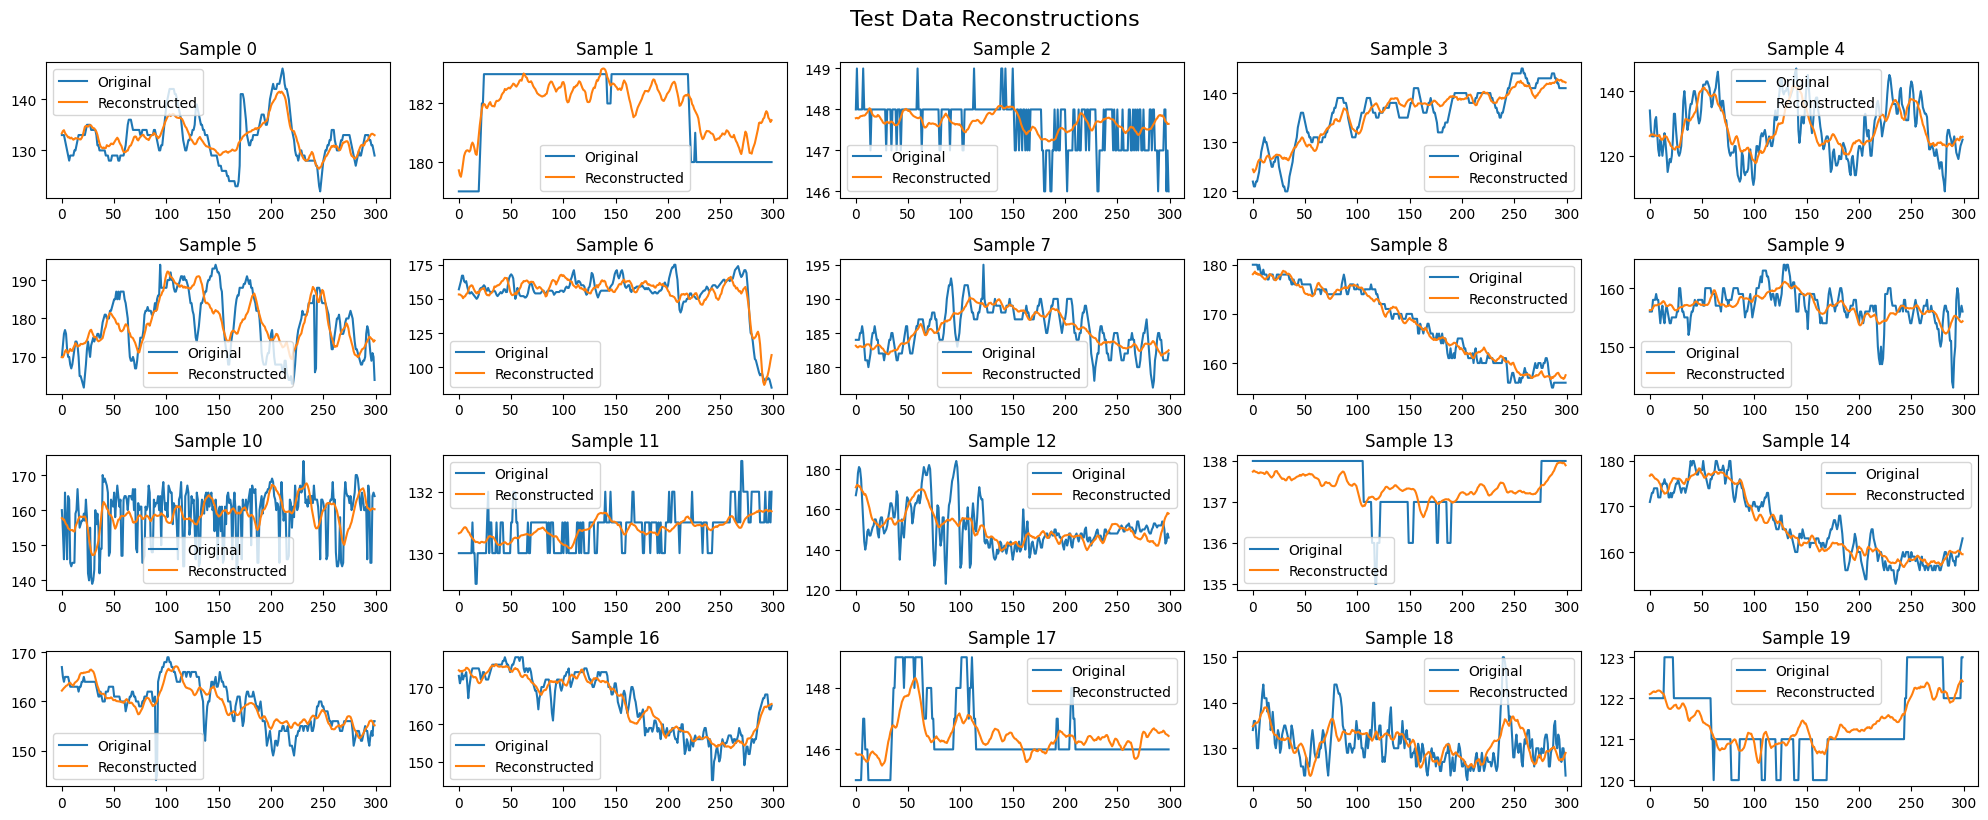

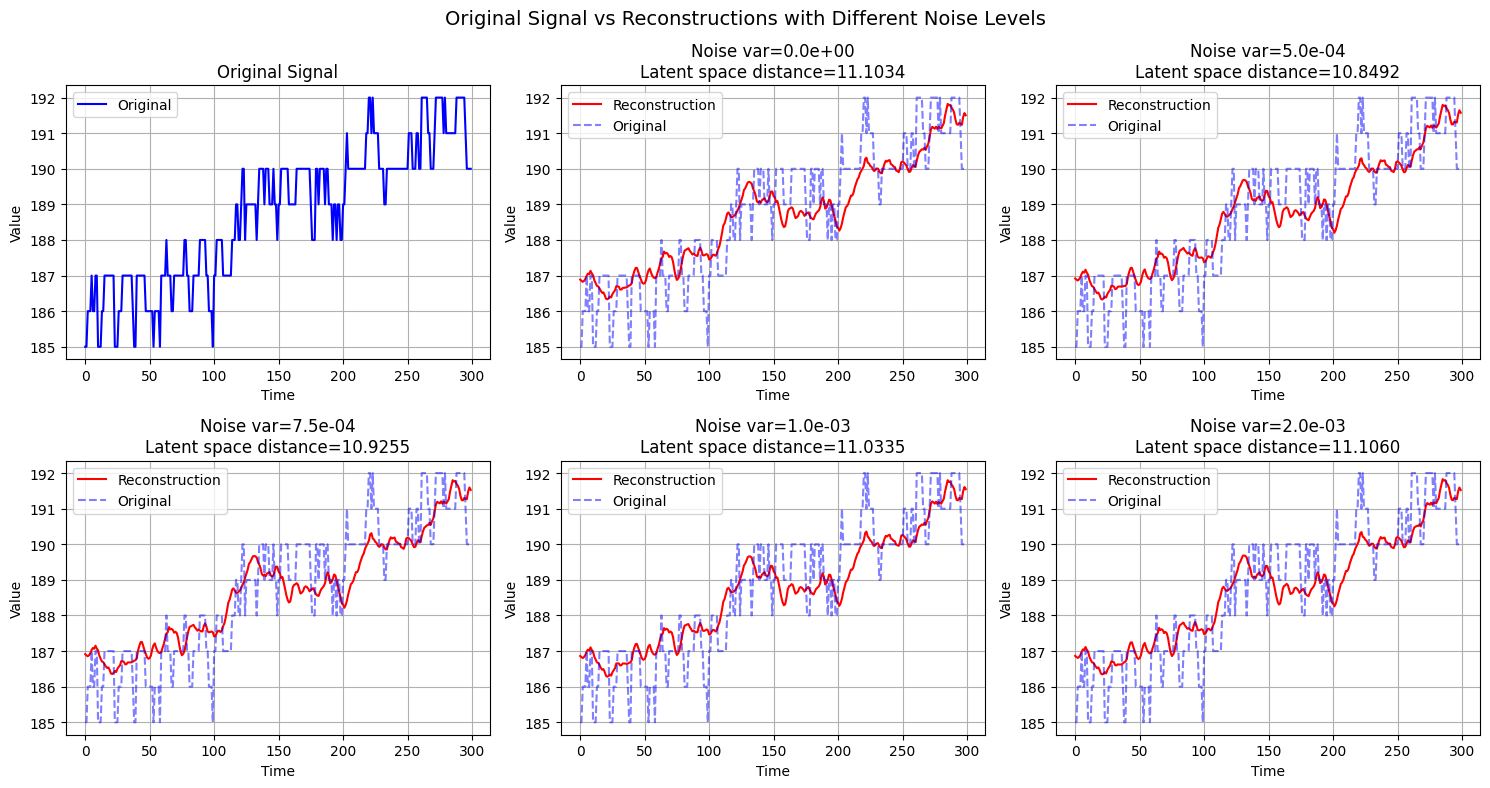

In [8]:
# eval clip 
eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)

# eval vae
plot_reconstructions(model, train_dataloader, title="Training Data Reconstructions")
plot_reconstructions(model, test_dataloader, title="Test Data Reconstructions")
plot_reconstruction_from_distances(model, train_dataloader)


In [ ]:
# %load_ext autoreload
# %autoreload 1
# %aimport eval

distance_ratios = [1, 50]
df = df_train.iloc[:1,].copy()
print(config_dict['text_col_ls'])
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['text1', 'ts_description', 'demo'],
                                                             distance_ratios =distance_ratios)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios)

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['text2', 'ts_description', 'demo'],
                                                             distance_ratios =distance_ratios)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios)

In [ ]:
# %load_ext autoreload
# %autoreload 1
# %aimport eval

distance_ratios = [1, 50]
df = df_train.iloc[:1,].copy()
df['text1'] = "Low amount of consecutive increases."
df['text2'] = "High amount of consecutive increases."
# df['text1'] = "Low variability."
# df['text2'] = "High variability."

print(config_dict['text_col_ls'])
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios =distance_ratios)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios)

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text2', 'demo'],
                                                             distance_ratios =distance_ratios)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios)

##### 